In [97]:
import sys
import os
import logging
sys.path.insert(1, os.path.join(sys.path[0], '../../src'))
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)

In [98]:
import torch
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from darts.dataprocessing.transformers.scaler import Scaler
from sklearn.preprocessing import MinMaxScaler
from darts import concatenate

In [99]:
from datasets import ShellDataset, WeatherEcadDataset
from visualization import plot_time_series_predictions
from eval import print_metrics

### Load Dataset

In [100]:
dataset = ShellDataset(subset=4)
data = dataset.load_dataset()

# Transform splits
target_scaler = Scaler(MinMaxScaler())
train_series = target_scaler.fit_transform(data['train'])
test_series = target_scaler.transform(data['test'])


Loaded 4 time series each with length 365


In [101]:
# Load Covariates
weather_dataset = WeatherEcadDataset()
past_covariates = weather_dataset.load_covariates()

# Scale Covariates
covariates_scaler = Scaler(MinMaxScaler())
past_covariates = covariates_scaler.fit_transform(past_covariates)

In [102]:
print("Number of data points in train, test: ", len(data['train'][0]),  len(data['test'][0]))

Number of data points in train, test:  292 73


### Set Experiment Parameters

In [103]:
FORECAST_HORIZON = 7

# Local Training

In [104]:
predictions = {}

#### ARIMA

In [105]:
def load_arimamodel():
    from darts.models import ARIMA
    return ARIMA(
        p=30,
        d=1,
        q=30
    )

In [106]:
%%capture
predictions_arima = []
for train_series_single, test_series_single in zip(train_series, test_series):
    model = load_arimamodel()

    model.fit(
        train_series_single,
    )

    forecast = model.historical_forecasts(
        series=concatenate([train_series_single, test_series_single]),
        start=test_series_single.start_time(),
        forecast_horizon=FORECAST_HORIZON,
        retrain=False
    )
    
    predictions_arima.append(forecast)
predictions_arima = target_scaler.inverse_transform(predictions_arima)
predictions['ARIMA'] = predictions_arima

## Create Encoder

In [107]:
from darts.utils.timeseries_generation import holidays_timeseries

add_encoders = {
    'cyclic': {'future': ['month']},
    'datetime_attribute': {'future': ['dayofweek', 'weekday']},
    'position': {'past': ['relative'], 'future': ['relative']},
    'custom': {'past': [lambda idx: (idx.year - 1950) / 50]},
}

## NHITS

In [108]:
from darts.models import NHiTSModel

def load_nhitsmodel():
    return NHiTSModel(
        nr_epochs_val_period=1,
        input_chunk_length=30,
        output_chunk_length=FORECAST_HORIZON,
        random_state=0,
        pl_trainer_kwargs={"callbacks": [EarlyStopping(monitor="val_loss", patience=10, min_delta=0.01, mode='min')], "log_every_n_steps": 1},
    )

In [109]:
%%capture
predictions_nhits = []
for train_series_single, test_series_single in zip(train_series, test_series):
    train_series_single_train, train_series_single_val = train_series_single.split_after(0.7)

    model = load_nhitsmodel()

    model.fit(
        train_series_single_train,
        val_series=train_series_single_val,
        past_covariates=past_covariates,
        val_past_covariates=past_covariates
    )

    forecast = model.historical_forecasts(
        series=concatenate([train_series_single, test_series_single]),
        past_covariates=past_covariates,
        start=test_series_single.start_time(),
        forecast_horizon=FORECAST_HORIZON,
        retrain=False
    )
    
    predictions_nhits.append(forecast)
predictions_nhits = target_scaler.inverse_transform(predictions_nhits)
predictions['NHiTS'] = predictions_nhits

# Global Training

In [110]:
def train_global_model(load_model_func, train_series, test_series, past_covariates, target_scaler, forecast_horizon, train_split=0.7):
    train_series_train, train_series_valid = [], []
    for train_series_single in train_series:
        train_series_single_train, train_series_single_valid = train_series_single.split_after(train_split)
        train_series_train.append(train_series_single_train)
        train_series_valid.append(train_series_single_valid)

    model = load_model_func()

    model.fit(
        series=train_series_train,
        val_series=train_series_valid,
        val_past_covariates=[past_covariates] * len(train_series),
        past_covariates=[past_covariates] * len(train_series),
    )

    predictions = []
    for train_series_single, test_series_single in zip(train_series, test_series):
        forecast = model.historical_forecasts(
            series=concatenate([train_series_single, test_series_single]),
            past_covariates=past_covariates,
            start=test_series_single.start_time(),
            forecast_horizon=forecast_horizon,
            retrain=False
        )
        predictions.append(forecast)
    predictions = target_scaler.inverse_transform(predictions)
    return predictions

In [111]:
%%capture
predictions_nhits_global = train_global_model(load_nhitsmodel, train_series, test_series, past_covariates, target_scaler, FORECAST_HORIZON, train_split=0.7)

predictions['NHiTS Global'] = predictions_nhits_global


# Results

Forecast Horizon: 7
Model        | MAPE       | RMSE      
-----------------------------------------
ARIMA        | 59.3727    | 161.8996  
NHiTS        | 53.6336    | 179.4401  
NHiTS Global | 35.0588    | 144.4856  




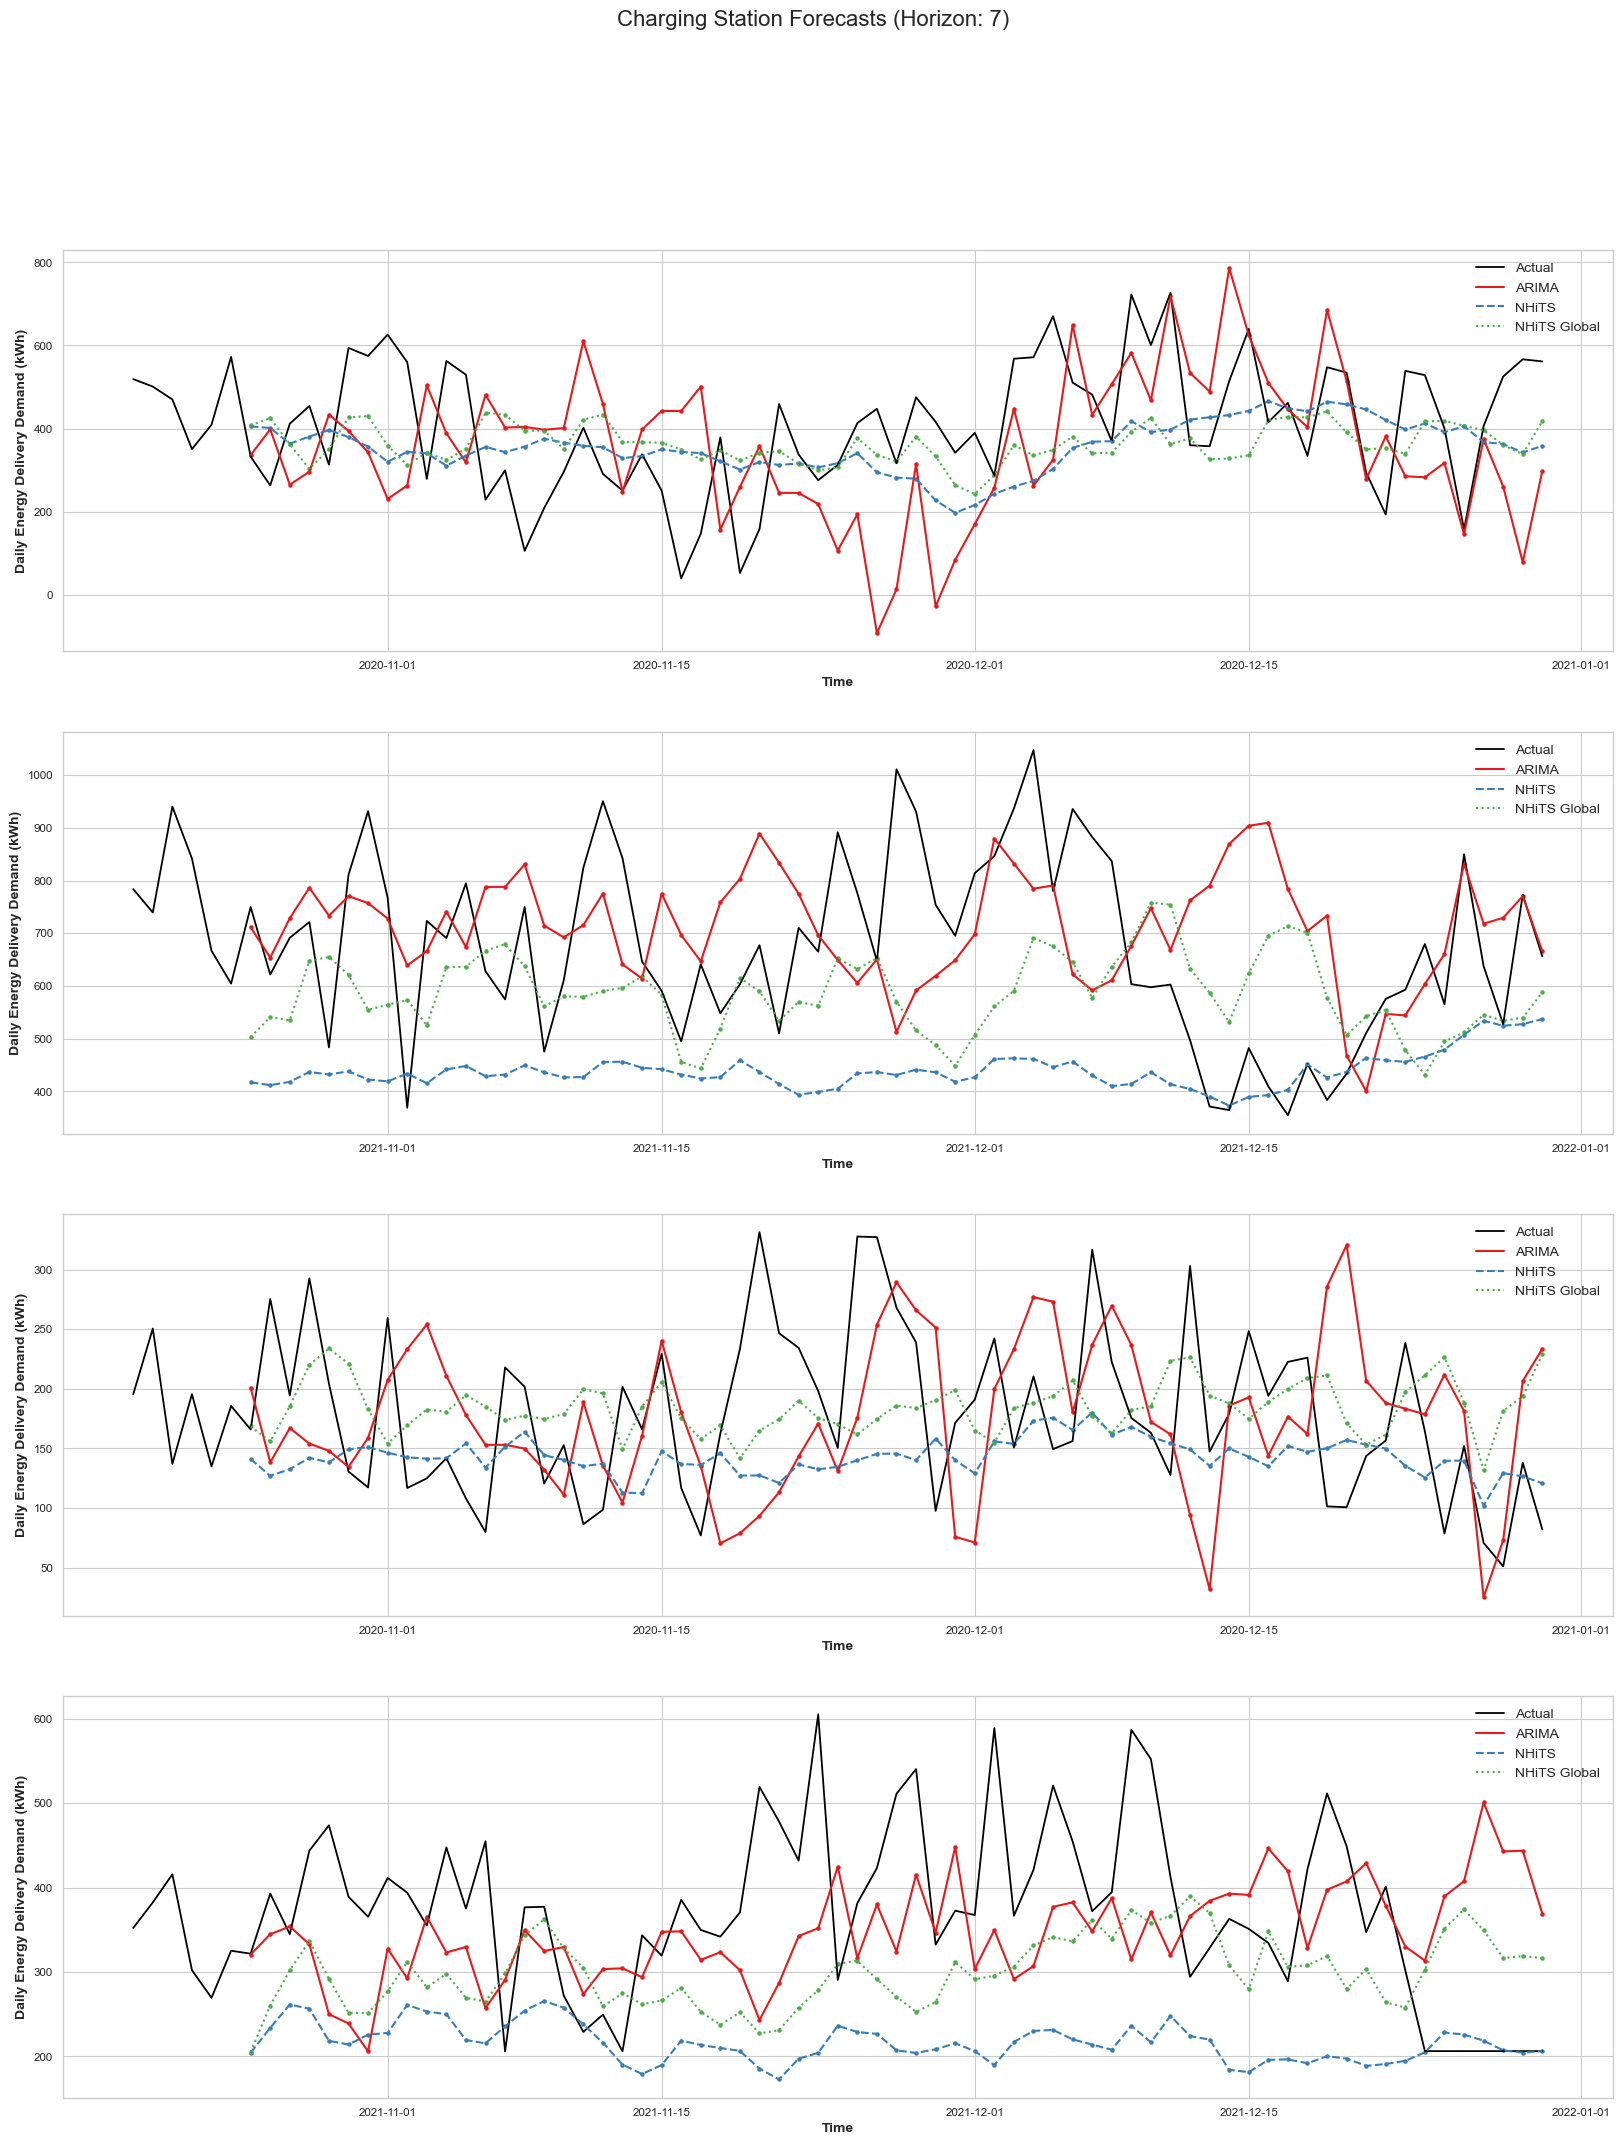

In [112]:
print_metrics(predictions, data['test'], FORECAST_HORIZON)
plot_time_series_predictions(predictions, data['test'], FORECAST_HORIZON)